In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import VGG16

In [2]:
# Step 1: Load and Preprocess Data
def load_and_preprocess_data():
    print("Loading and preprocessing MNIST data...")
    from tensorflow.keras.datasets import mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Here I have normalized pixel values to [0, 1] for better convergence during training.
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Here I have reshaped the data to fit CNN input (28x28 images with 1 channel).
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # Here I have one-hot encoded labels to prepare them for categorical classification.
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return X_train, y_train, X_test, y_test

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
def perform_eda(X_train, y_train):
    print("\nPerforming Exploratory Data Analysis...")
    # Here I have displayed some sample images to understand the dataset visually.
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(X_train[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {np.argmax(y_train[i])}")
        ax.axis('off')
    plt.show()

    # Here I have plotted the distribution of classes in the training set.
    sns.countplot(x=np.argmax(y_train, axis=1))
    plt.title("Class Distribution in Training Data")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

In [4]:
# Step 3: Data Augmentation
def apply_data_augmentation(X_train, y_train):
    print("\nApplying Data Augmentation...")
    # Here I have used ImageDataGenerator to apply random transformations like rotation, shifting, and zooming.
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1
    )
    datagen.fit(X_train)
    return datagen

In [5]:
# Step 4: Build and Train Neural Network Model
def build_and_train_model(X_train, y_train, X_test, y_test, datagen=None):
    print("\nBuilding and training a Convolutional Neural Network (CNN)...")
    # Here I have built a CNN model with convolutional, pooling, dropout, and dense layers.
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Here I have compiled the model using the Adam optimizer and categorical cross-entropy loss.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    # Here I have defined callbacks for early stopping, learning rate scheduling, and model checkpointing.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
    def lr_scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * 0.95
    lr_callback = LearningRateScheduler(lr_scheduler)

    # Here I have trained the model with or without data augmentation.
    if datagen:
        history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                            epochs=20,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpoint, lr_callback])
    else:
        history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpoint, lr_callback])

    # Here I have plotted the training and validation accuracy and loss over epochs.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

    return model


In [6]:
# Step 5: Evaluate the Model
def evaluate_model(model, X_test, y_test):
    print("\nEvaluating the model on test data...")
    # Here I have made predictions and converted them into class labels.
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Here I have printed a classification report to evaluate precision, recall, and F1-score.
    print(classification_report(y_true, y_pred_classes))

    # Here I have plotted a confusion matrix to visualize true vs predicted labels.
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Here I have performed ROC-AUC analysis to evaluate the model's performance for each class.
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC-AUC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [7]:
# Step 6: Transfer Learning
def transfer_learning_example(X_train, y_train, X_test, y_test):
    print("\nUsing Transfer Learning with VGG16...")
    # Here I have resized images to match the input shape of the VGG16 model (224x224x3).
    from tensorflow.keras.preprocessing.image import array_to_img
    X_train_resized = np.array([array_to_img(img).resize((224, 224)) for img in X_train])
    X_test_resized = np.array([array_to_img(img).resize((224, 224)) for img in X_test])

    # Here I have converted grayscale images to RGB by repeating the single channel three times.
    X_train_resized = np.repeat(X_train_resized, 3, axis=-1)
    X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

    # Here I have normalized pixel values to [0, 1].
    X_train_resized = X_train_resized.astype('float32') / 255.0
    X_test_resized = X_test_resized.astype('float32') / 255.0

    # Here I have loaded the pre-trained VGG16 model and frozen its layers for feature extraction.
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Here I have added custom layers on top of the VGG16 base model.
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    # Here I have compiled the model with the Adam optimizer and categorical cross-entropy loss.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    # Here I have trained the model using the resized dataset.
    history = model.fit(X_train_resized, y_train, epochs=5, batch_size=32,
                        validation_data=(X_test_resized, y_test))

    # Here I have plotted the training and validation accuracy and loss over epochs.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

Loading and preprocessing MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Performing Exploratory Data Analysis...


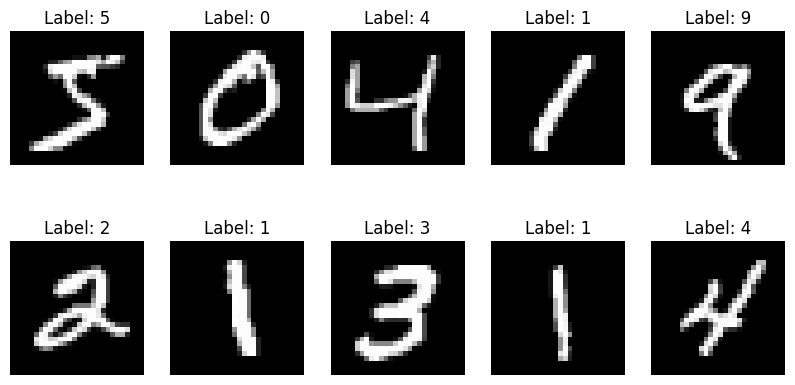

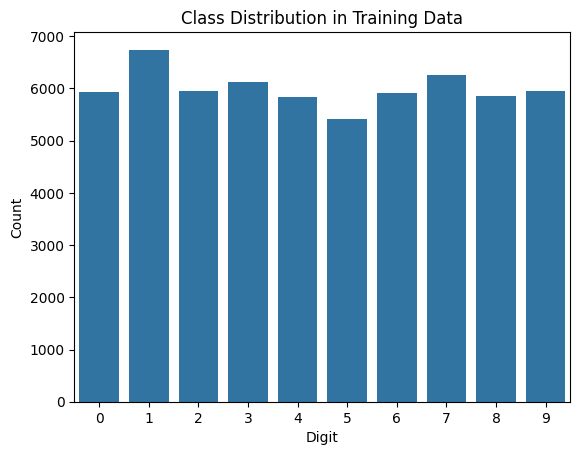


Applying Data Augmentation...

Building and training a Convolutional Neural Network (CNN)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6986 - loss: 0.9083

938/938 ━━━━━━━━━━━━━━━━━━━━ 86s 85ms/step - accuracy: 0.6987 - loss: 0.9079 - val_accuracy: 0.9825 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9317 - loss: 0.2225

938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.9318 - loss: 0.2224 - val_accuracy: 0.9872 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9473 - loss: 0.1735

938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 72ms/step - accuracy: 0.9473 - loss: 0.1735 - val_accuracy: 0.9900 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9571 - loss: 0.1426

938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.9571 - loss: 0.1426 - val_accuracy: 0.9904 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9606 - loss: 0.1284

938/938 ━━━━━━━━━━━━━━━━━━━━ 87s 78ms/step - accuracy: 0.9606 - loss: 0.1284 - val_accuracy: 0.9921 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9646 - loss: 0.1227

938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.9646 - loss: 0.1227 - val_accuracy: 0.9926 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9680 - loss: 0.1096

938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.9680 - loss: 0.1096 - val_accuracy: 0.9928 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.9695 - loss: 0.1047 - val_accuracy: 0.9927 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9707 - loss: 0.0994

938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - accuracy: 0.9707 - loss: 0.0994 - val_accuracy: 0.9937 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9727 - loss: 0.0957

938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.9727 - loss: 0.0957 - val_accuracy: 0.9938 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9733 - loss: 0.0942

938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.9733 - loss: 0.0942 - val_accuracy: 0.9951 - val_loss: 0.0168 - learning_rate: 9.5000e-04
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9742 - loss: 0.0833 - val_accuracy: 0.9941 - val_loss: 0.0174 - learning_rate: 9.0250e-04
Epoch 13/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.9764 - loss: 0.0832 - val_accuracy: 0.9951 - val_loss: 0.0155 - learning_rate: 8.5737e-04
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.9762 - loss: 0.0793 - val_accuracy: 0.9938 - val_loss: 0.0170 - learning_rate: 8.1451e-04
Epoch 15/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.9783 - loss: 0.0749 - val_accuracy: 0.9946 - val_loss: 0.0147 - learning_rate: 7.7378e-04
Epoch 16/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 72ms/step - accuracy: 0.9779 - loss: 0.0744 - val_accuracy: 0.9950 - val_loss: 0.0153 - learning_rate: 7.3509e-04
Epoch 17/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - ac

938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 72ms/step - accuracy: 0.9799 - loss: 0.0697 - val_accuracy: 0.9953 - val_loss: 0.0155 - learning_rate: 6.9834e-04
Epoch 18/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.9796 - loss: 0.0712 - val_accuracy: 0.9945 - val_loss: 0.0179 - learning_rate: 6.6342e-04


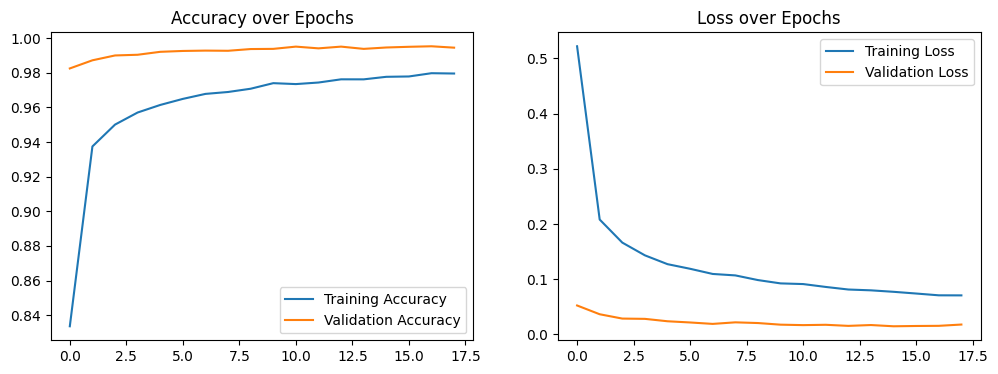


Evaluating the model on test data...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



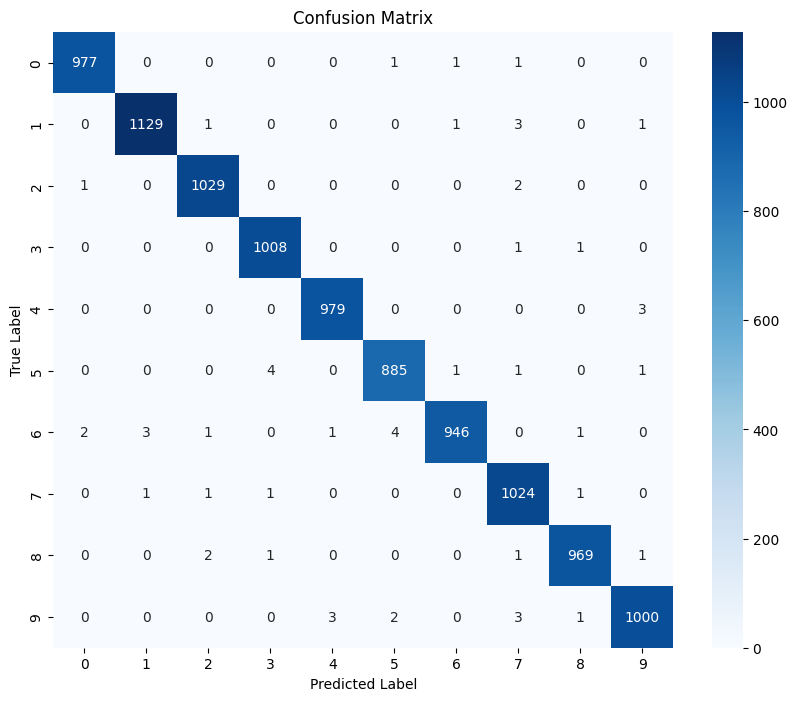

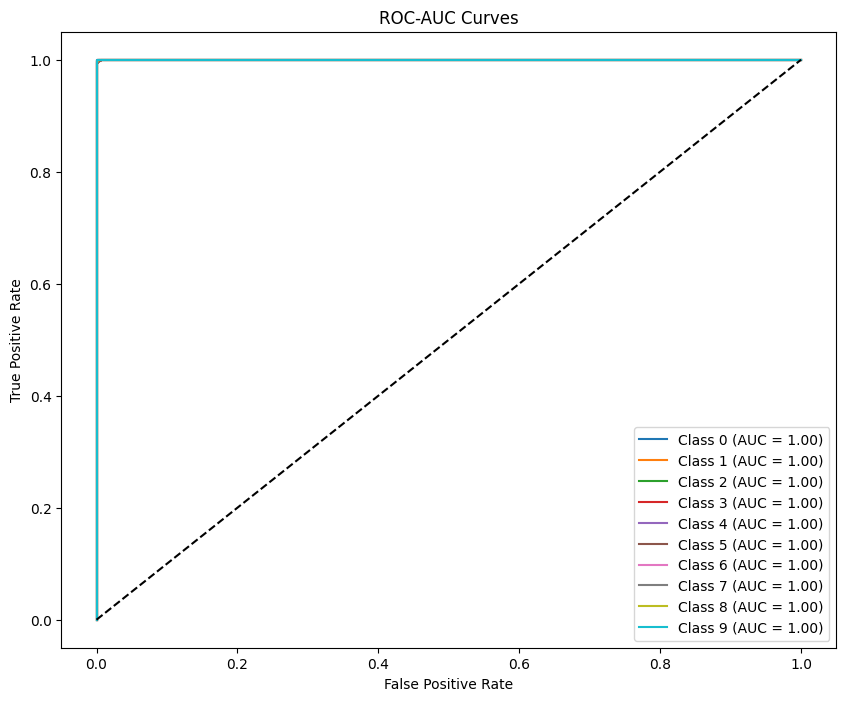


Using Transfer Learning with VGG16...


In [ ]:
# Main Function
if __name__ == "__main__":
    # Here I have loaded and preprocessed the MNIST dataset.
    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # Here I have performed exploratory data analysis (EDA) to understand the dataset.
    perform_eda(X_train, y_train)

    # Here I have applied data augmentation to artificially increase the size of the dataset.
    datagen = apply_data_augmentation(X_train, y_train)

    # Here I have built and trained a CNN model with advanced features like dropout and callbacks.
    model = build_and_train_model(X_train, y_train, X_test, y_test, datagen)

    # Here I have evaluated the model using classification reports, confusion matrices, and ROC-AUC analysis.
    evaluate_model(model, X_test, y_test)

    # Here I have demonstrated transfer learning using the pre-trained VGG16 model.
    transfer_learning_example(X_train, y_train, X_test, y_test)